### Training

In [38]:
import importlib

import utils.sound_utils as su
import utils.train_utils as tu
import utils.filter_utils as filter
import utils.plot_utils as pu
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import wget

import os
import sys
import importlib
import pickle
import numpy as np
import pandas as pd

importlib.reload(su)
importlib.reload(tu)
importlib.reload(pu)
importlib.reload(filter)


<module 'utils.filter_utils' from 'c:\\Users\\gonza\\OneDrive\\Documentos\\Gonzalo\\Especializacion\\inteligencia_embebida\\esp32_loopback\\python\\utils\\filter_utils.py'>

In [32]:

#wget.download('https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip')
#wget.download('https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv')
#wget.download('https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv')

In [2]:
labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

In [7]:
train_labels = pd.read_csv("data/train_labels.csv")
test_labels = pd.read_csv("data/test_files.csv")

In [35]:
train_labels.head()

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2


In [36]:
test_labels.head()

,filename
0,1
1,2
2,3
3,5
4,6


In [37]:
dataset = tu.upload_dataset("data/audios")

In [38]:
len(dataset)

3083

In [ ]:
sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))
filtered_data = []


for _, audio in dataset:
    filtered_aux = []
    for value in audio:
        absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
        filtered_aux.append(filter_ma.calculate_ma(absolute))
    filtered_data.append(filtered_aux)
    
    

In [12]:
with open('data/filtered_data.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)

NameError: name 'filtered_data' is not defined

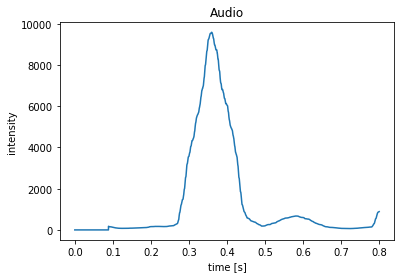

In [ ]:
from utils.sound_utils import plot_audio

plot_audio(filtered_data[0], sample_rate)

In [ ]:
noise_gate_data = []
noise_gate = su.NoiseGate(open_threshold=0.1, close_threshold=0.1, hold=0)
for data in filtered_data:
    filtered_data_list, init, end = noise_gate.split(data, sample_rate)
    if len(filtered_data_list) == 1:
        noise_gate_data.append(filtered_data_list[0])
    elif len(filtered_data_list) > 0:
        noise_gate_data.append(filtered_data_list[0])
    else:
        noise_gate_data.append([])

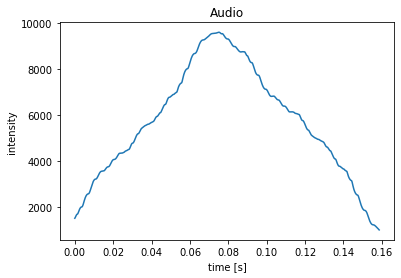

In [ ]:
plot_audio(noise_gate_data[0], sample_rate)

In [ ]:
extracted_data = []
for data in noise_gate_data:
    extractor = su.FeatureExtractor(data, sample_rate)
    extracted_data.append(extractor.extract_features())

In [ ]:
with open('data/extracted_data.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)

In [43]:
file = open('data/extracted_data.pkl', 'rb')
extracted_data = pickle.load(file)

In [44]:
extracted_data[0]

[0.1310657596371882,
 0.2925075840371226,
 59,
 0.47545765203494544,
 0.05790615121587316]

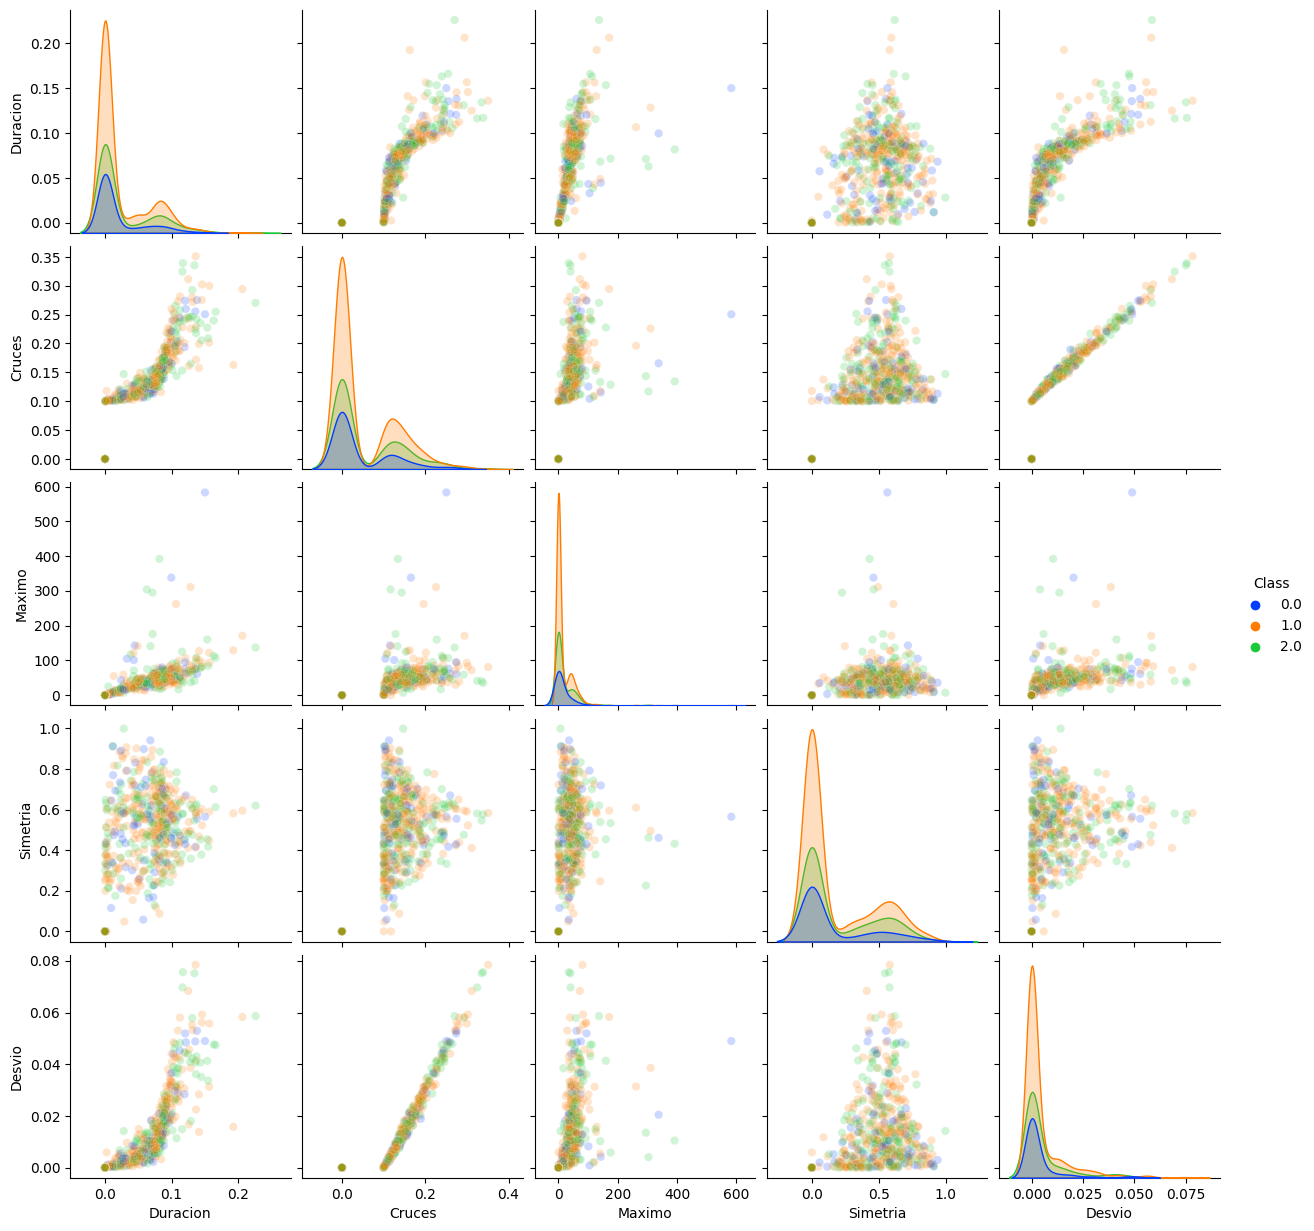

In [45]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(extracted_data, columns=colnames)
df_train.insert(len(df_train.columns), "Class", train_labels["label"])

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

### Training

In [46]:
X_data = np.array(extracted_data)
X_data.size
len(extracted_data)

3083

In [47]:
X_data = extracted_data
y_data = train_labels.label.to_list()

In [48]:
X_train = []
y_train = []

test_indexes = test_labels.filename.to_list()
counter = 0
for i, value in enumerate(extracted_data):
    if value == []:
        continue
    if i not in test_indexes:
        X_train.append(value)
        y_train.append(y_data[counter])
        counter += 1


In [49]:
X_train

[[0.1310657596371882,
  0.2925075840371226,
  59,
  0.47545765203494544,
  0.05790615121587316],
 [0.0, 0, 0, 0, 0.0],
 [0.0, 0, 0, 0, 0.0],
 [0.12077097505668934,
  0.24388534785108099,
  107,
  0.49215520280731617,
  0.044301757697725305],
 [0.07351473922902495,
  0.1369525066517619,
  49,
  0.33664829694374204,
  0.009689256107846886],
 [0.0, 0, 0, 0, 0.0],
 [0.05219954648526077,
  0.11742700493676425,
  49,
  0.8233437577522973,
  0.003999846394588338],
 [0.09106575963718821,
  0.18734300371608625,
  61,
  0.34339009640321866,
  0.02636931837081796],
 [0.0, 0, 0, 0, 0.0],
 [0.08907029478458049,
  0.17599986911262933,
  69,
  0.7191926853001497,
  0.0205716845131425],
 [0.02018140589569161,
  0.10654602338899152,
  13,
  0.31203169263396685,
  0.0021927974648699613],
 [0.02893424036281179,
  0.1020572397538004,
  33,
  0.04849847758037784,
  0.0003822824011103908],
 [0.11056689342403628,
  0.1865515851646659,
  99,
  0.6479309822205167,
  0.025556147243548735],
 [0.0, 0, 0, 0, 0.0],

In [50]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 255, 1: 827, 2: 450}

#### Oversampling

In [51]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler(sampling_strategy='all')
X_train, y_train = oversample.fit_resample(np.array(X_train), np.array(y_train))

In [52]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 827, 1: 827, 2: 827}

#### Split dataset

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.33,
                                                    random_state=42)

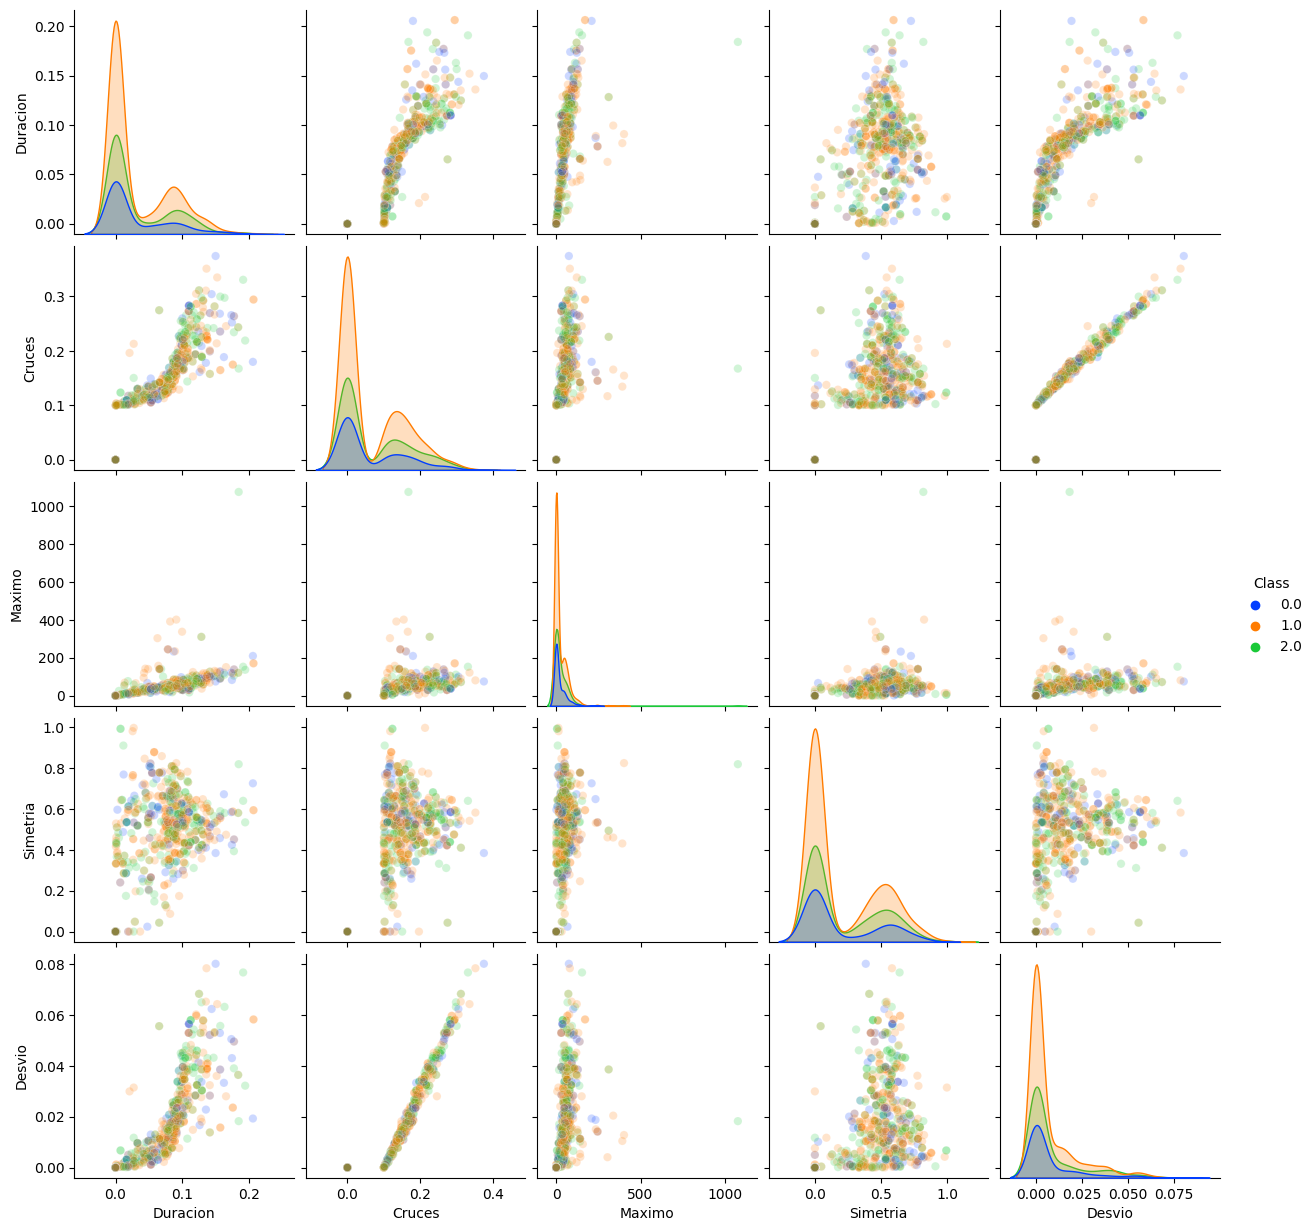

In [54]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(X_train, columns=colnames)
df_train.insert(len(df_train.columns), "Class", train_labels["label"])

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

#### Grid search and training

In [55]:
models = {}
params = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2, 3, 4]}
model = tu.get_best_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test, params, models, "model_dt") 


{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}
Grid search time: 0.1227466999553144 s
              precision    recall  f1-score   support

           0    0.45455   0.01748   0.03367       286
           1    0.43026   0.82642   0.56589       265
           2    0.50167   0.55970   0.52910       268

    accuracy                        0.45665       819
   macro avg    0.46216   0.46787   0.37622       819
weighted avg    0.46211   0.45665   0.36800       819

Training time: 0.003054899978451431 s


#### Results

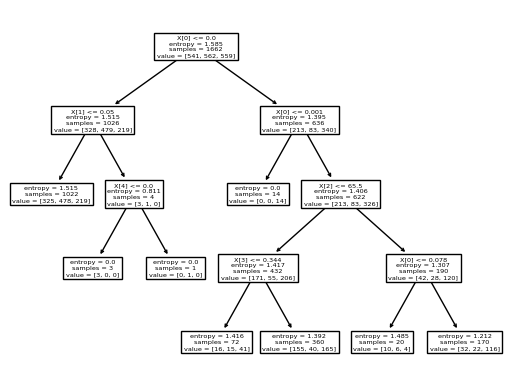

In [56]:
tree.plot_tree(model.model)
plt.savefig('tree.png', format='png',bbox_inches = "tight")